In [74]:
import os
import sys
import inspect
import torch
from typing import Union
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
import cv2

In [75]:
import numba
@numba.jit(nopython=True)
def get_normals_from_depth(depth_img_arr: np.ndarray) -> np.ndarray:
    n, m = depth_img_arr.shape
    normals_img_arr = np.zeros((n, m, 3), dtype=np.float32)

    for x in range(1, n - 1):
        for y in range(1, m - 1):
            dzdx = (depth_img_arr[x + 1, y] - depth_img_arr[x - 1, y]) / 2.0
            dzdy = (depth_img_arr[x, y + 1] - depth_img_arr[x, y - 1]) / 2.0

            direction = np.array([-dzdx, -dzdy, 1.0], dtype=np.float32)
            magnitude = np.sqrt((direction ** 2).sum())
            normals_img_arr[x, y] = direction / magnitude
    return normals_img_arr

In [76]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [77]:
color_img = cv2.imread('../images/color_production_2.png')
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

depth_img = cv2.imread('../images/depth_production_2.png', cv2.IMREAD_UNCHANGED)
depth_img = depth_img.astype(np.float32)
print(depth_img.dtype)

float32


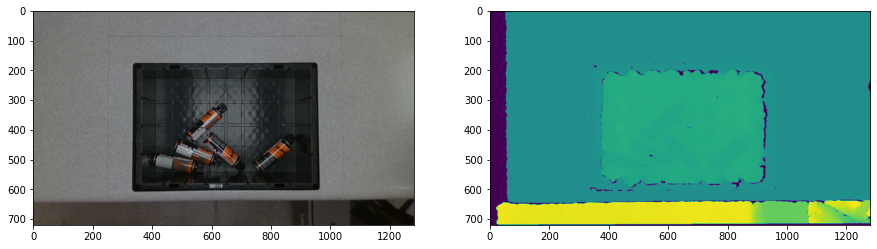

In [78]:
f, axes = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(15)
axes[0].imshow(color_img)
axes[1].imshow(depth_img)

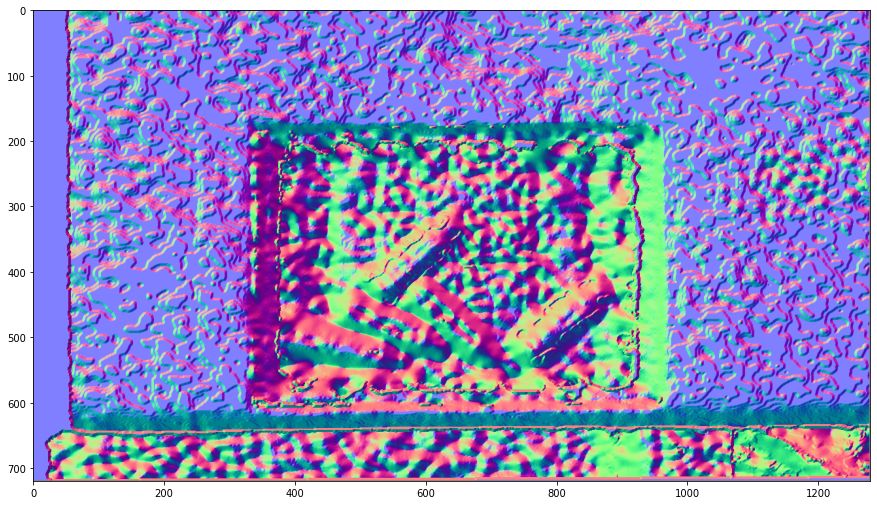

In [82]:
plt.figure(figsize=(15, 15))
plt.imshow(
    normalize(
        get_normals_from_depth(cv2.blur(depth_img,(3, 3)))
    )
)

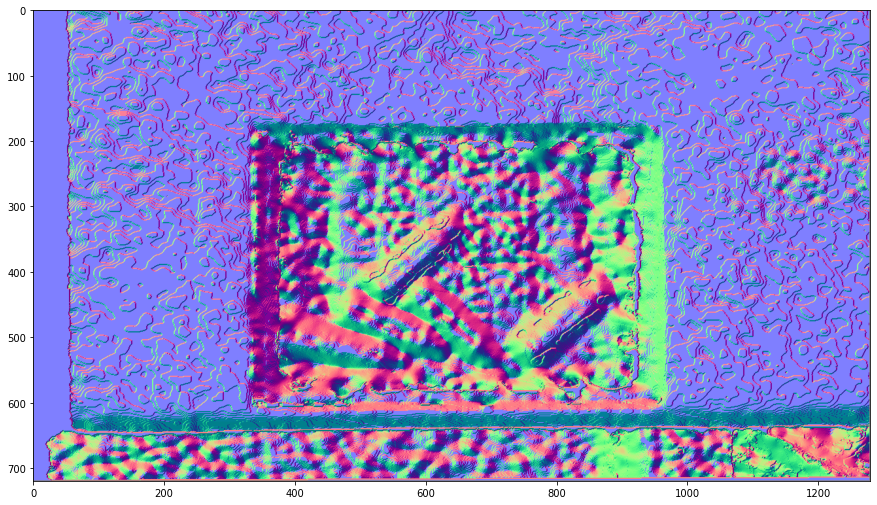

In [83]:
plt.figure(figsize=(15, 15))
plt.imshow(
    normalize(
        get_normals_from_depth(depth_img.astype(dtype=np.float32))
    )
)

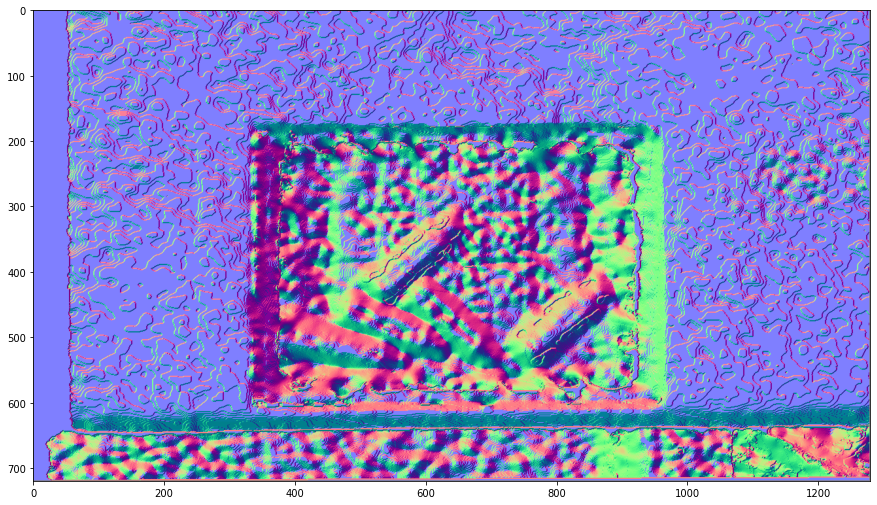

In [84]:
plt.figure(figsize=(15, 15))
plt.imshow(
    normalize(
        get_normals_from_depth(depth_img)
    )
)

In [86]:
color_img.dtype

dtype('uint8')

In [87]:
transform = A.Compose([
            A.ColorJitter(
                brightness=0.2, contrast=0.2,  saturation=0.2, hue=0.2, always_apply=False, p=1
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1
            ),
            A.HueSaturationValue(
                hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=1
            ),
            A.GaussianBlur(
                blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=1
            ),
        ])

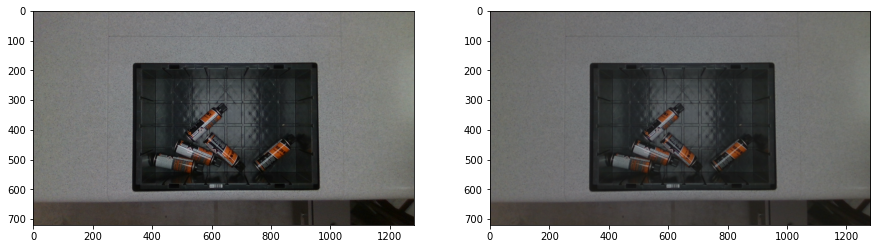

In [140]:
transformedf = transform(image=color_img.astype(np.uint8))['image']
transformedint = transform(image=color_img)['image']
                
    
f, axes = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(15)
axes[0].imshow(normalize(transformedf.astype(np.float32)))
axes[1].imshow(transformedint)

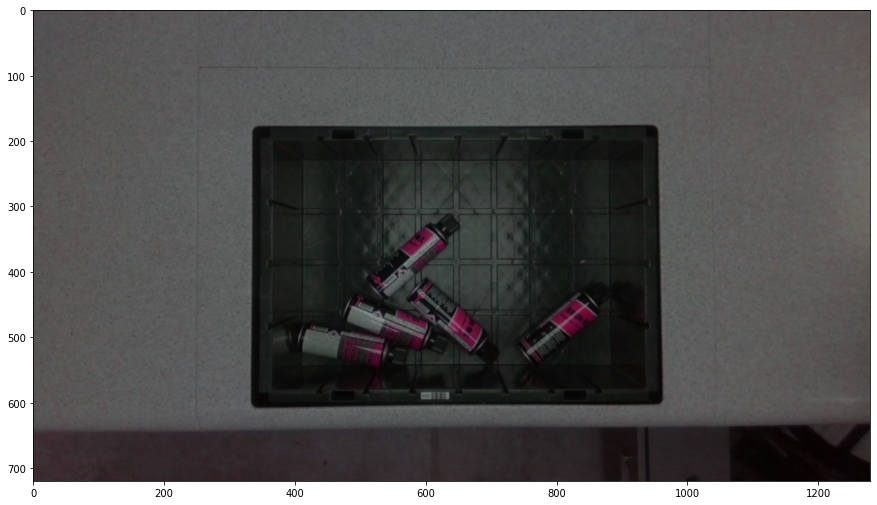

In [125]:
plt.figure(figsize=(15, 15))
plt.imshow(transformedint.astype(np.float32).astype(np.uint8))

In [104]:
np.sum(transformedint.astype(np.float32) == transformedint)

2764800

In [121]:
transformedint[transformedint != transformedint.astype(np.float32).astype(np.uint8)]

array([], dtype=uint8)

In [119]:
transformedint[transformedint != transformedint.astype(np.float32).astype(np.int8)].astype(np.float32)

array([128., 128., 128., ..., 128., 129., 129.], dtype=float32)